# Disciplines

In [1]:
from gemseo_oad_training.models import aerodynamic
from gemseo_oad_training.models import approach
from gemseo_oad_training.models import battery
from gemseo_oad_training.models import climb
from gemseo_oad_training.models import engine
from gemseo_oad_training.models import fuel_tank
from gemseo_oad_training.models import geometry
from gemseo_oad_training.models import mass
from gemseo_oad_training.models import mission
from gemseo_oad_training.models import operating_cost
from gemseo_oad_training.models import take_off
from gemseo_oad_training.models import total_mass

In [2]:
from gemseo.disciplines.auto_py import AutoPyDiscipline
discipline_aerodynamic = AutoPyDiscipline(aerodynamic)
discipline_approach = AutoPyDiscipline(approach)
discipline_battery = AutoPyDiscipline(battery)
discipline_climb = AutoPyDiscipline(climb)
discipline_engine = AutoPyDiscipline(engine)
discipline_fuel_tank = AutoPyDiscipline(fuel_tank)
discipline_geometry = AutoPyDiscipline(geometry)
discipline_mass = AutoPyDiscipline(mass)
discipline_mission = AutoPyDiscipline(mission)
discipline_operating_cost = AutoPyDiscipline(operating_cost)
discipline_take_off = AutoPyDiscipline(take_off)
discipline_total_mass = AutoPyDiscipline(total_mass)


In [3]:
disciplines = [discipline_aerodynamic,discipline_approach,discipline_battery,discipline_climb,discipline_engine,
               discipline_fuel_tank,discipline_geometry,discipline_mass,discipline_mission,discipline_operating_cost,
               discipline_take_off,discipline_total_mass]

# Design space

In [4]:
from gemseo import configure_logger
configure_logger()

<RootLogger root (INFO)>

In [5]:
from gemseo_oad_training.unit import convert_from
from gemseo.algos.parameter_space import ParameterSpace
from utils import update_default_inputs

x_def={'slst':100000,'n_pax':20.0,'area':111.58,'ar':8.8912,'fuel_type':'liquid_h2','engine_type':'turbofan','design_range':5500000}
update_default_inputs(disciplines,x_def)

uncertain_space = ParameterSpace()
uncertain_space.add_random_variable("gi","OTTriangularDistribution", minimum=0.35, mode=0.4, maximum=0.405)
uncertain_space.add_random_variable("vi","OTTriangularDistribution", minimum=0.755, mode=0.800, maximum=0.805)
uncertain_space.add_random_variable("aef","OTTriangularDistribution", minimum=0.99, mode=1., maximum=1.03)
uncertain_space.add_random_variable("cef","OTTriangularDistribution", minimum=0.99, mode=1., maximum=1.03)
uncertain_space.add_random_variable("sef","OTTriangularDistribution", minimum=0.99, mode=1., maximum=1.03)

In [6]:
from gemseo import sample_disciplines
from gemseo.disciplines.surrogate import SurrogateDiscipline

training_dataset = sample_disciplines(disciplines, uncertain_space, ["tofl", "vapp","vz","span","length","fm","mtom"], algo_name="OT_MONTE_CARLO", n_samples=100)

    INFO - 17:30:08: *** Start Sampling execution ***
    INFO - 17:30:08: Sampling
    INFO - 17:30:08:    Disciplines: aerodynamic approach battery climb engine fuel_tank geometry mass mission operating_cost take_off total_mass
    INFO - 17:30:08:    MDO formulation: MDF
    INFO - 17:30:08: Running the algorithm OT_MONTE_CARLO:
    INFO - 17:30:09:    100%|██████████| 100/100 [00:01<00:00, 66.76 it/sec]
    INFO - 17:30:09: *** End Sampling execution (time: 0:00:01.520276) ***


In [7]:
import matplotlib.pyplot as plt
import pprint

In [8]:
surrogate_discipline = SurrogateDiscipline("PolynomialRegressor", training_dataset)

In [9]:
rmse = surrogate_discipline.get_error_measure("RMSEMeasure")
rmse.compute_learning_measure(as_dict=True)

{'fm': array([1.07501165e-06]),
 'length': array([0.]),
 'mtom': array([0.42060336]),
 'span': array([3.55271368e-15]),
 'tofl': array([0.02240277]),
 'vapp': array([0.0002465]),
 'vz': array([0.00010001])}

In [10]:
rmse.compute_cross_validation_measure(as_dict=True)

{'fm': array([1.49857153e-06]),
 'length': array([3.55271368e-15]),
 'mtom': array([0.62946814]),
 'span': array([0.]),
 'tofl': array([0.03430852]),
 'vapp': array([0.00036351]),
 'vz': array([0.000143])}

In [11]:
from gemseo.uncertainty.statistics.empirical_statistics import EmpiricalStatistics

In [12]:
statistics = EmpiricalStatistics(training_dataset)
mean = statistics.compute_mean()
mean

{'aef': array([1.00852155]),
 'cef': array([1.00566636]),
 'fm': array([0.21505233]),
 'gi': array([0.38656094]),
 'length': array([18.08333333]),
 'mtom': array([42770.76663658]),
 'sef': array([1.00613398]),
 'span': array([31.497303]),
 'tofl': array([907.21519506]),
 'vapp': array([55.62187432]),
 'vi': array([0.78770926]),
 'vz': array([10.9857781])}

In [13]:
variance = statistics.compute_variance()
variance

{'aef': array([6.81645596e-05]),
 'cef': array([6.36776767e-05]),
 'fm': array([0.00047429]),
 'gi': array([0.00015218]),
 'length': array([0.]),
 'mtom': array([285180.20449285]),
 'sef': array([6.78384882e-05]),
 'span': array([5.04870979e-29]),
 'tofl': array([411.920635]),
 'vapp': array([0.14680487]),
 'vi': array([0.00013086]),
 'vz': array([0.08897203])}

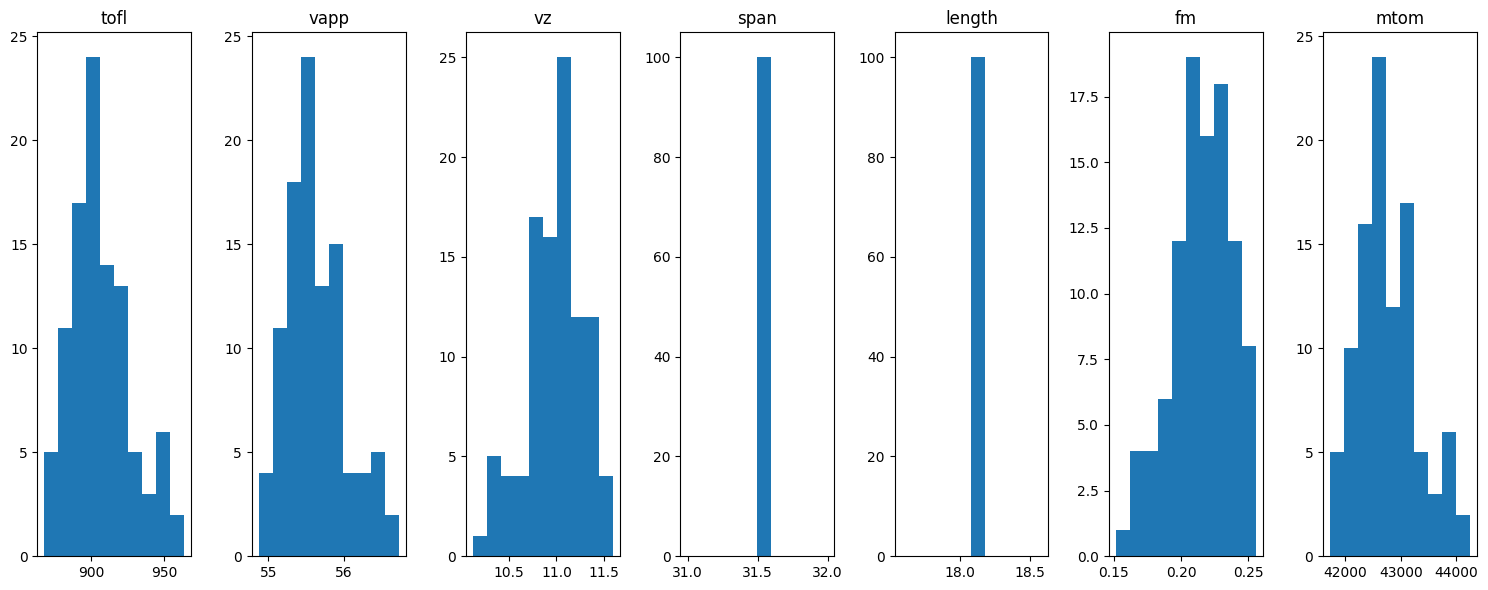

In [14]:
fig, axes = plt.subplots(1, 7,figsize=(15,6))
for ax, name in zip(axes, ["tofl", "vapp","vz","span","length","fm","mtom"]):
    ax.hist(training_dataset.get_view(variable_names=name))
    ax.set_title(name)
plt.tight_layout()
plt.show()

In [15]:
from gemseo.uncertainty.sensitivity.sobol_analysis import SobolAnalysis


In [16]:
sobol = SobolAnalysis()
sobol.compute_samples([surrogate_discipline], uncertain_space, 100)

 WARNING - 17:30:12: No coupling in MDA, switching chain_linearize to True.
    INFO - 17:30:12: *** Start SobolAnalysisSamplingPhase execution ***
    INFO - 17:30:12: SobolAnalysisSamplingPhase
    INFO - 17:30:12:    Disciplines: PolyReg_Sampling
    INFO - 17:30:12:    MDO formulation: MDF
    INFO - 17:30:12: Running the algorithm OT_SOBOL_INDICES:
    INFO - 17:30:13:    100%|██████████| 96/96 [00:00<00:00, 99.40 it/sec]
    INFO - 17:30:13: *** End SobolAnalysisSamplingPhase execution (time: 0:00:00.987073) ***


GROUP        inputs                                           outputs  \
VARIABLE         gi        vi       aef       cef       sef        fm   
COMPONENT         0         0         0         0         0         0   
0          0.394131  0.779313  1.028623  1.018127  1.006415  0.176421   
1          0.366964  0.764723  1.014139  0.994315  0.994671  0.189322   
2          0.394951  0.799486  1.009626  1.024286  1.003858  0.210720   
3          0.375284  0.796036  1.013230  0.997688  1.001509  0.234495   
4          0.375179  0.799914  1.017345  0.996241  1.006883  0.239817   
..              ...       ...       ...       ...       ...       ...   
91         0.365560  0.778220  1.020575  1.009792  1.001509  0.188673   
92         0.398343  0.776086  1.007875  1.003573  1.006883  0.199791   
93         0.387046  0.772072  1.007799  1.001951  1.003720  0.195502   
94         0.400720  0.781155  1.002871  0.993853  1.014974  0.222021   
95         0.394662  0.778199  0.997953  1.006463  1.010079  0.205475   

GROUP                                                                 \
VARIABLE      length          mtom       span        tofl       vapp   
COMPONENT          0             0          0           0          0   
0          18.083333  42495.849586  31.497303  896.726913  55.353073   
1          18.083333  42964.549060  31.497303  914.446129  55.789572   
2          18.083333  42615.168092  31.497303  901.211595  55.450155   
3          18.083333  43162.727104  31.497303  922.003719  55.922450   
4          18.083333  43328.119033  31.497303  928.338547  56.038972   
..               ...           ...        ...         ...        ...   
91         18.083333  43412.035864  31.497303  931.567466  56.051091   
92         18.083333  42214.354329  31.497303  886.159868  55.228660   
93         18.083333  42494.617188  31.497303  896.650334  55.437001   
94         18.083333  42304.254305  31.497303  889.536107  55.332502   
95         18.083333  42422.111640  31.497303  893.928647  55.385880   

GROUP                 
VARIABLE          vz  
COMPONENT          0  
0          11.010003  
1          10.841178  
2          11.061141  
3          10.739224  
4          10.624745  
..               ...  
91         10.560051  
92         11.296236  
93         11.139062  
94         11.277103  
95         11.241050  

[96 rows x 12 columns]

In [17]:
sobol.compute_indices(output_names=["tofl", "vapp","vz","fm","mtom"])

SobolAnalysis.SensitivityIndices(first={'tofl': [{'gi': array([1.76468632]), 'vi': array([0.1635511]), 'aef': array([0.35254349]), 'cef': array([0.31135011]), 'sef': array([0.50162686])}], 'vapp': [{'gi': array([1.5143411]), 'vi': array([0.10445372]), 'aef': array([0.19696086]), 'cef': array([0.19590368]), 'sef': array([0.41053066])}], 'vz': [{'gi': array([1.8523936]), 'vi': array([0.12025457]), 'aef': array([0.73577391]), 'cef': array([0.33356707]), 'sef': array([0.47898785])}], 'fm': [{'gi': array([-0.30236605]), 'vi': array([0.32223908]), 'aef': array([-0.17886212]), 'cef': array([-0.08293282]), 'sef': array([-0.30239057])}], 'mtom': [{'gi': array([1.77159581]), 'vi': array([0.16504041]), 'aef': array([0.35237397]), 'cef': array([0.31108419]), 'sef': array([0.50530234])}]}, second={'tofl': [{'gi': {'gi': array([[0.]]), 'vi': array([[-0.57596112]]), 'aef': array([[-1.02069994]]), 'cef': array([[-0.917849]]), 'sef': array([[-0.22332815]])}, 'vi': {'gi': array([[-0.57596112]]), 'vi': a

In [18]:
pprint.pprint(sobol.indices.first)
pprint.pprint(sobol.indices.total)

{'fm': [{'aef': array([-0.17886212]),
         'cef': array([-0.08293282]),
         'gi': array([-0.30236605]),
         'sef': array([-0.30239057]),
         'vi': array([0.32223908])}],
 'mtom': [{'aef': array([0.35237397]),
           'cef': array([0.31108419]),
           'gi': array([1.77159581]),
           'sef': array([0.50530234]),
           'vi': array([0.16504041])}],
 'tofl': [{'aef': array([0.35254349]),
           'cef': array([0.31135011]),
           'gi': array([1.76468632]),
           'sef': array([0.50162686]),
           'vi': array([0.1635511])}],
 'vapp': [{'aef': array([0.19696086]),
           'cef': array([0.19590368]),
           'gi': array([1.5143411]),
           'sef': array([0.41053066]),
           'vi': array([0.10445372])}],
 'vz': [{'aef': array([0.73577391]),
         'cef': array([0.33356707]),
         'gi': array([1.8523936]),
         'sef': array([0.47898785]),
         'vi': array([0.12025457])}]}
{'fm': [{'aef': array([0.18198058]),
       

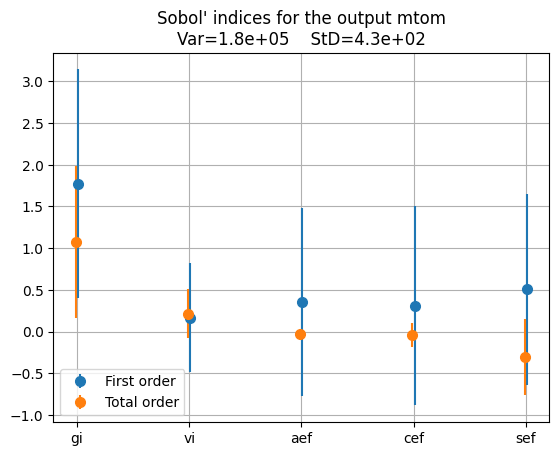

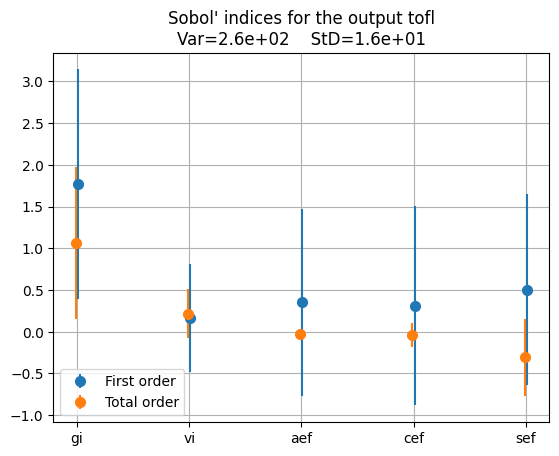

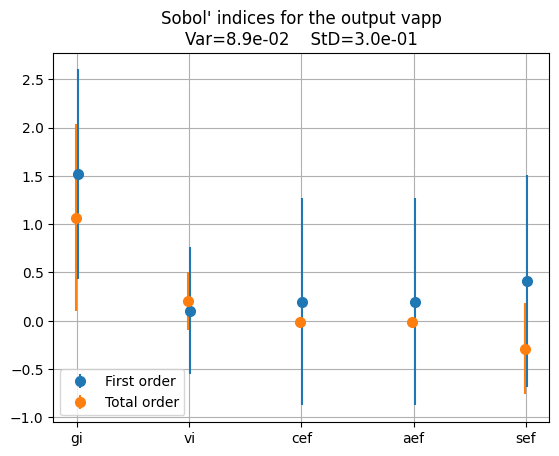

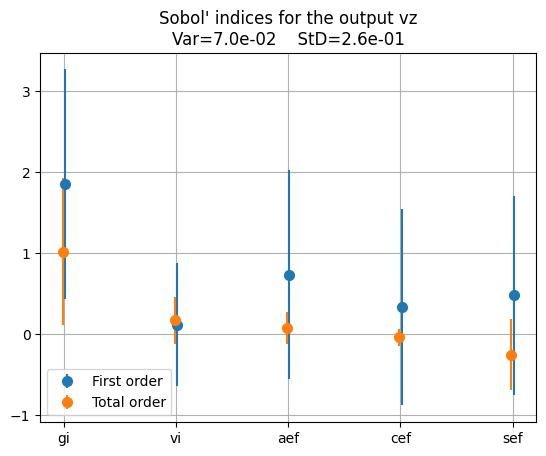

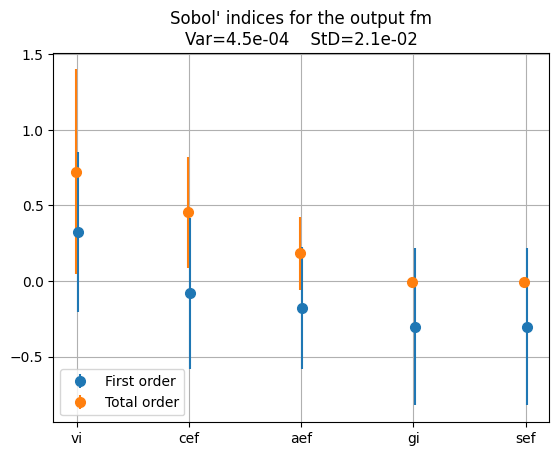

In [19]:
plt.show(sobol.plot("mtom", save=False, show=True))
plt.show(sobol.plot("tofl", save=False, show=True))
plt.show(sobol.plot("vapp", save=False, show=True))
plt.show(sobol.plot("vz", save=False, show=True))
plt.show(sobol.plot("fm", save=False, show=True))